In [28]:
import scipy.io as sio
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import psd_array_welch
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
import pandas as pd
import seaborn as sns


In [29]:
# mat_content = sio.loadmat('deap/s01.mat')
# # print(mat_content['data'])
# lables = mat_content['labels']
# print(lables.shape)
# # print(lables)
# data=mat_content['data']
# print(data.shape)



In [30]:
#read the 22 dataset and combine them into one
labels=[]
data=[]
for i in range(1,23):
    if(i<10):
        mat_content = sio.loadmat('deap/s0'+str(i)+'.mat')
        labels.append( mat_content['labels'])
        data.append( mat_content['data'])
    else:
        mat_content = sio.loadmat('deap/s'+str(i)+'.mat')
        labels.append( mat_content['labels'])
        data.append(mat_content['data'])

In [31]:
labels = np.array(labels)
print(labels.shape)   # (22, 40, 4) 22 subjects, 40 trials, 4 labels

(22, 40, 4)


In [32]:
data = np.array(data)
print(data.shape)   # (22, 40, 40, 8064) 22 subjects, 40 trials, 40 channels, 8064 samples

(22, 40, 40, 8064)


In [33]:
# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)
print(labels.shape)
df_label_rating=pd.DataFrame(labels,columns=['valence','arousal','dominance','liking'])
print(df_label_rating.head())

data = np.array(data)
data = data.flatten()
data = data.reshape(880, 40, 8064) # 880 trials, 40 channels, 8064 samples
print(data.shape)



(880, 4)
   valence  arousal  dominance  liking
0     7.71     7.60       6.90    7.83
1     8.10     7.31       7.28    8.47
2     8.58     7.54       9.00    7.08
3     4.94     6.01       6.12    8.06
4     6.96     3.92       7.19    6.05
(880, 40, 8064)


<AxesSubplot: >

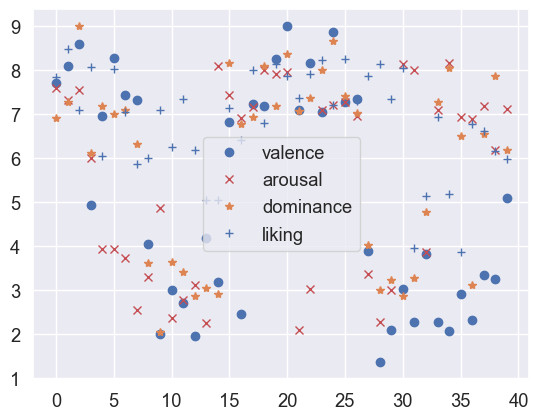

In [34]:
# plot the first 40 data
df_label_rating.iloc[0:40].plot(style=['o','rx','*','b+'])

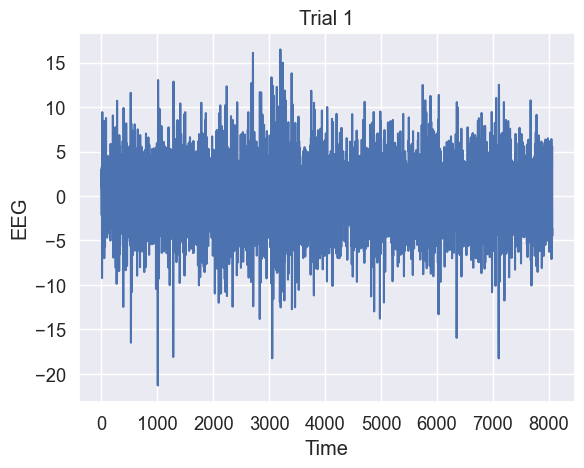

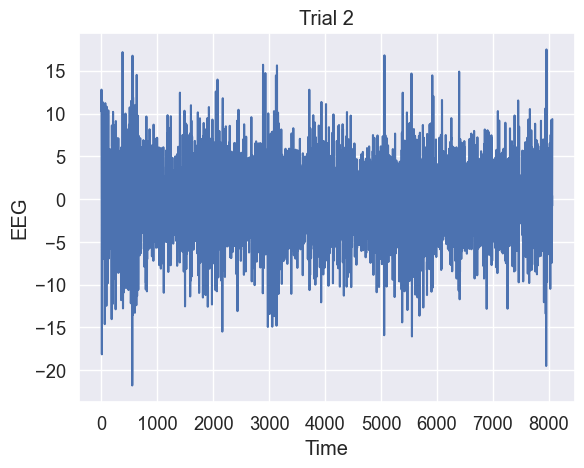

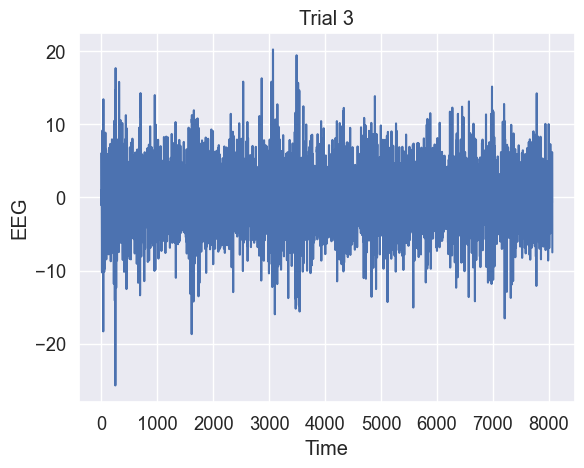

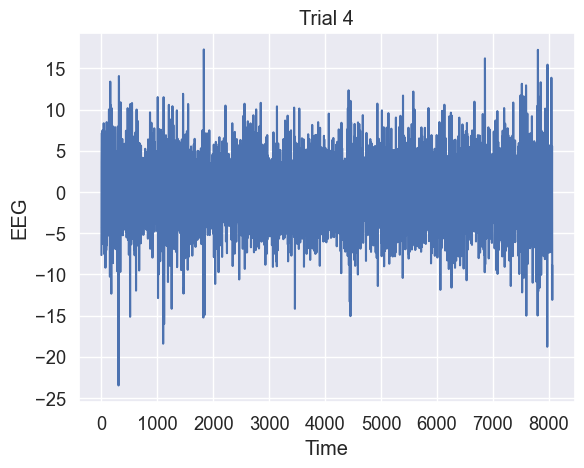

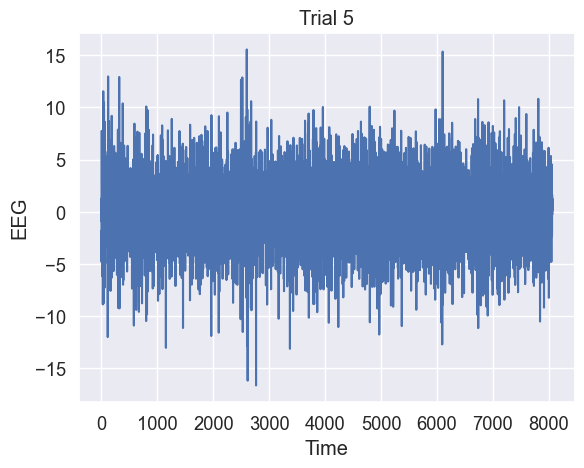

In [35]:
# plot data for the first 5 trials
for i in range(5):
    plt.figure()
    plt.plot(data[i,0,:])
    plt.title('Trial '+str(i+1))
    plt.xlabel('Time')
    plt.ylabel('EEG')
    plt.show()

In [36]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())



          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


<AxesSubplot: >

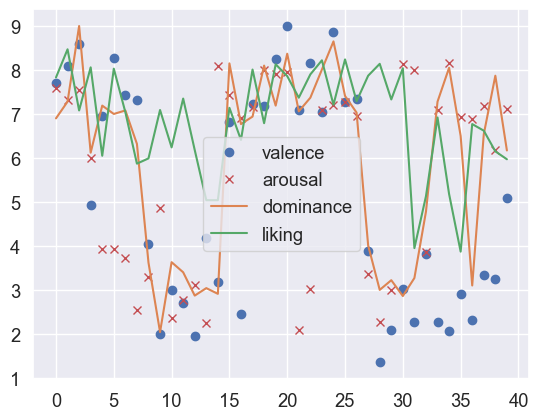

In [37]:
# plot the first 40 data
df_label_rating.iloc[0:40].plot(style=['o','rx'])

In [38]:
#Check positive/negative cases
# df_label_ratings['Valence'].plot.hist(bins=20)
# df_label_ratings['Arousal'].plot.hist(bins=20)
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
print(df_hahv.shape)
# High Arousal Negative Valence dataset
df_hanv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
print(df_hanv.shape)
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
print(df_lahv.shape)
# Low Arousal Negative Valence dataset
df_lanv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
print(df_lanv.shape)




(242, 2)
(200, 2)
(215, 2)
(223, 2)


In [39]:
#Separate EEG and non-EEG data

eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [40]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
    
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [41]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(880, 8, 8064)


In [42]:
# Theta band, first trial

# data_3d=mat_content['data']
# # data.shape
# print(data_3d.shape)



# # eeg_data_2d=np.reshape(data_3d,(data_3d.shape[0],data_3d.shape[1]*data_3d.shape[2]))
# data_to_plot=data[0,0,:]
# eeg_data_2d=np.reshape(data_to_plot,(data_to_plot.shape[0],-1))
# print(eeg_data_2d.shape)
# # print(eeg_data_2d)
# # print(eeg_data_2d[0][0])

# n_channels = eeg_data_2d.shape[0]
# # print(n_channels)
# channel_names=['Ch{}'.format(i) for i in range(n_channels)]
# # print(channel_names)
# sfreq=250
# info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')
# # print(info)
# raw = mne.io.RawArray(eeg_data_2d, info)
# # print(raw)
# raw.save('stim_101.fif', overwrite=True)
# raw.plot_psd(fmax=50)
# raw.plot(duration=5, n_channels=10, scalings='auto')

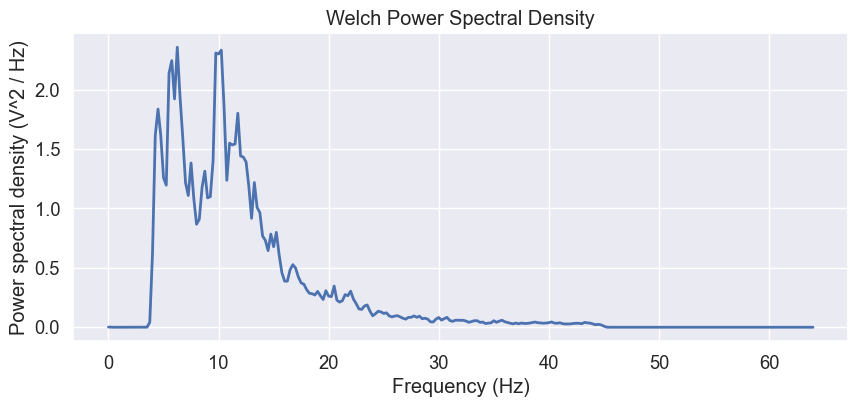

In [43]:
# Welch's feature extraction
sns.set(font_scale=1.2)
# Define sampling frequency and time vector
sfreq = 128
time = np.arange(eeg_data.size) / sfreq
win = 4 * sfreq  # 4 seconds window for time-frequency decomposition
freqs, psd = signal.welch(eeg_data[0,31], sfreq, nperseg=win)

# Plot the power spectral density
plt.figure(figsize=(10, 4))
plt.plot(freqs, psd, lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.title('Welch Power Spectral Density')
plt.show()





In [44]:
# Theta band power
# Define theta lower and upper limits
low, high = 4, 8
# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)



In [45]:
#alpha band power
# Define alpha lower and upper limits
low, high = 8, 12
# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)


In [46]:
#Beta band power
# Define beta lower and upper limits
low, high = 12, 30
# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)


In [47]:
#Gamma band power
# Define gamma lower and upper limits
low, high = 30, 50
# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)


In [48]:
#function to calculate band power
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band
    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg=(2/low)*sf
    # Compute the modified periodogram (Welch)
    freqs, psd = signal.welch(data, sf, nperseg=nperseg)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)
    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


In [49]:
def get_band_power(trial,channel,band):
    bd = (0,0)
    if band == 'theta':   # drownsiness, emotional connection, intuition, creativity
        bd = (4,8)
    elif band == 'alpha': # relaxation, meditation, calmness, focus, concentration
        bd = (8,12)
    elif band == 'beta':  # alertness, concentration, focus, memory, learning
        bd = (12,30)
    elif band == 'gamma': # cognition, perception, learning, multi-tasking
        bd = (30,50)
    return bandpower(eeg_data[trial,channel], 128, bd)



In [50]:
print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
1.1062125930881577


In [51]:
# info = mne.create_info(32, sfreq=128)
# print(info)
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)
raw_data = mne.io.RawArray(eeg_data[31], info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>
Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


In [52]:
mont1=mne.channels.make_dig_montage('biosemi32')
mont1.plot()

TypeError: ch_pos must be an instance of dict or None, got <class 'str'> instead.

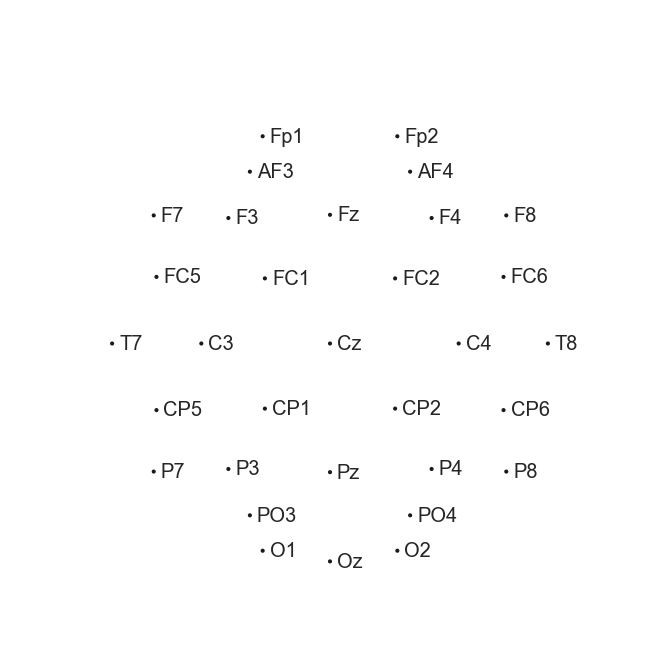

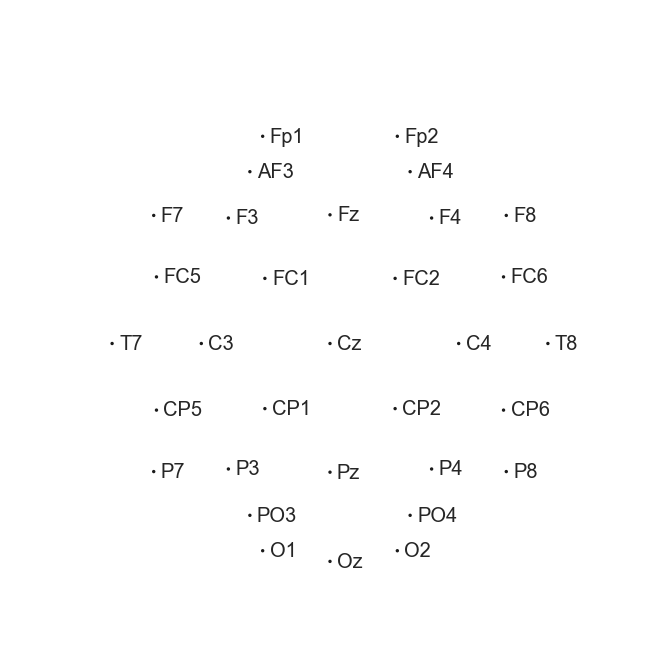

In [ ]:
#Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()
# montage = mne.channels.make_standard_montage('biosemi32', )
# channel_list = montage.get_positions()['ch_pos']
# mont1 = mne.channels.make_dig_montage(ch_pos=channel_list)
# mont1.plot()

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\Users\HXP\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


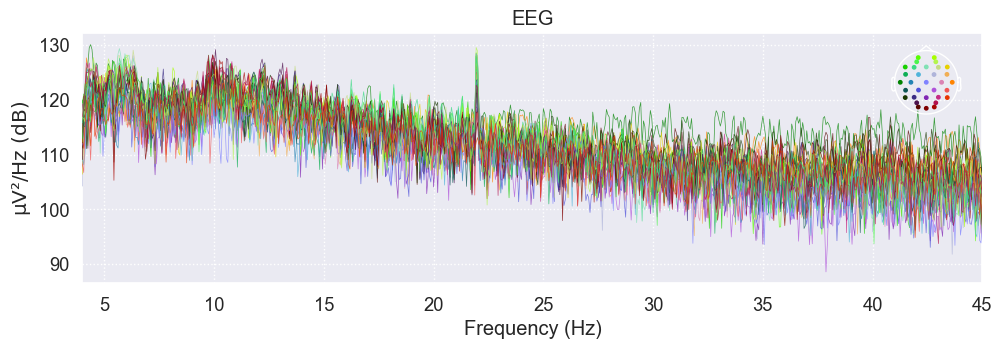

In [ ]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


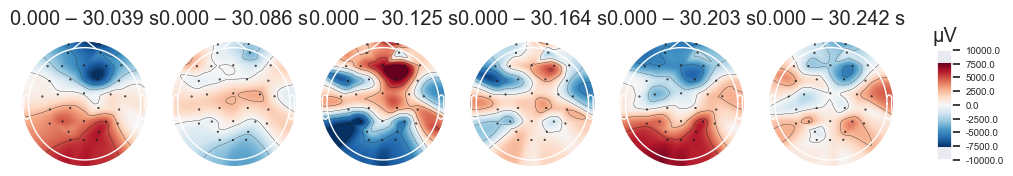

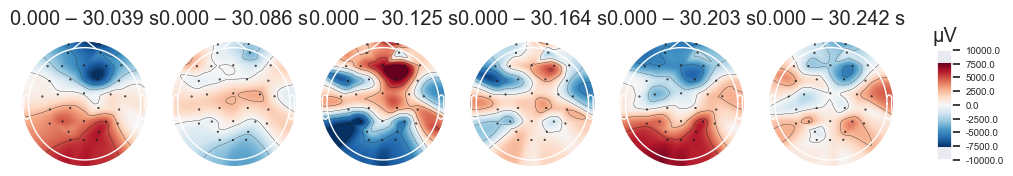

In [ ]:
# Theta band, first trial
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 

evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


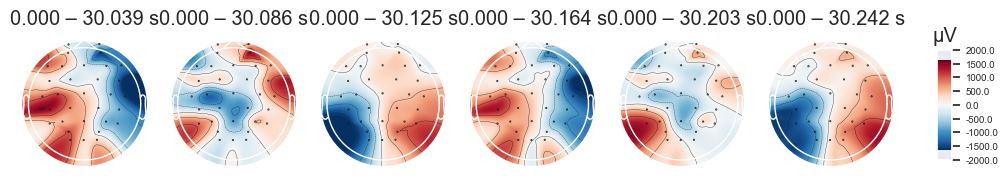

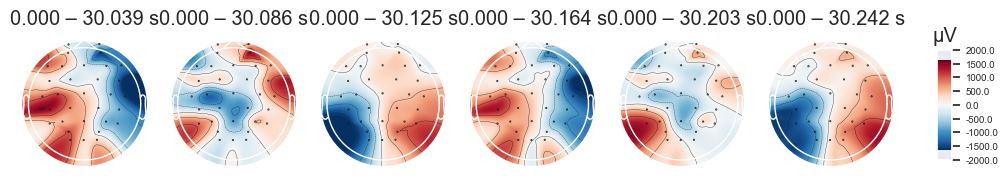

In [ ]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


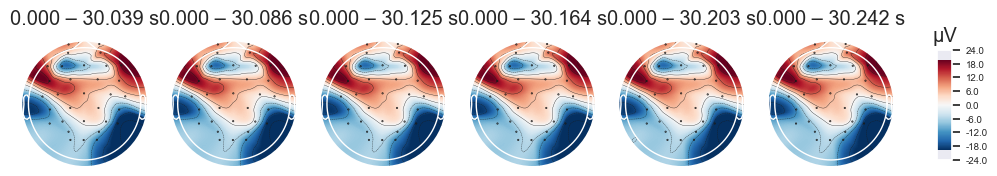

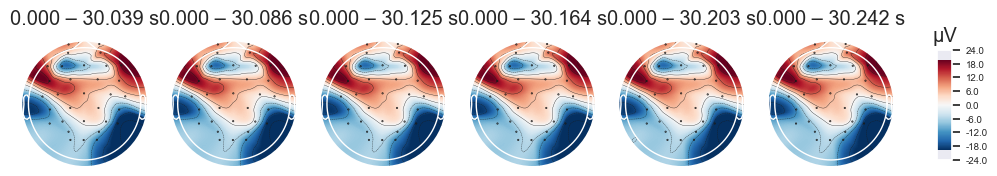

In [ ]:
# Beta band, first trial
evData_be = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_be.filter(12, 30)
evData_be.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')


Setting up band-pass filter from 30 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 57 samples (0.445 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


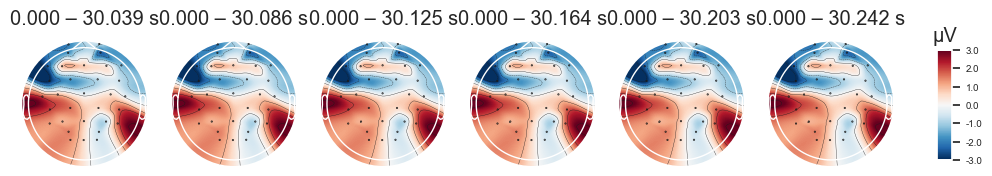

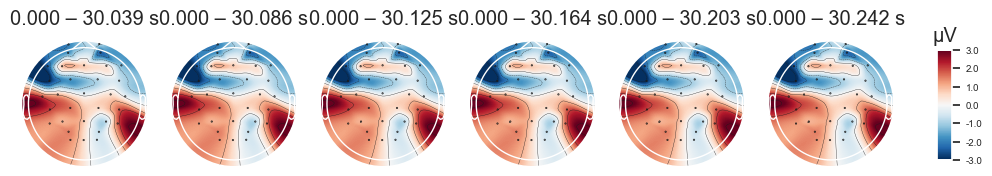

In [ ]:
# Gamma band, first trial
evData_ga = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_ga.filter(30, 50)
evData_ga.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')
